## Import

In [1]:
import pandas as pd
from fuzzywuzzy import fuzz, process
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import numpy as np

from sklearn.metrics import r2_score, mean_pinball_loss
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('default')
sns.set_palette("husl")

In [2]:
df_user_actions = pd.read_csv("task_2_users_actions.csv")

In [3]:
df_user_params = pd.read_csv("task_2_users_params.csv")

## EDA

In [ ]:
df_user_actions

In [ ]:
df_user_params

In [ ]:
df_user_params.id_user.value_counts()

Check for duplicates. Remove unnecessary duplicates.

In [4]:
dup_params  = df_user_params[df_user_params.duplicated(keep=False)]
dup_actions = df_user_actions[df_user_actions.duplicated(keep=False)]

ids_params  = set(dup_params['id_user'])
ids_actions = set(dup_actions['id_user'])

common_ids = ids_params.intersection(ids_actions)

print(f"Users duplicated in BOTH params and actions: {len(common_ids)}")

Users duplicated in BOTH params and actions: 39


In [5]:
len(dup_actions)

78

In [6]:
len(dup_params)

483083

In [7]:
unique_duplicate_params = len(dup_params.drop_duplicates())
unique_duplicate_actions = len(dup_actions.drop_duplicates())

print(f"Unique records with duplicates in params: {unique_duplicate_params}")
print(f"Unique records with duplicates in actions: {unique_duplicate_actions}")

Unique records with duplicates in params: 191956
Unique records with duplicates in actions: 39


In [8]:
df_user_params = df_user_params.drop_duplicates()
df_user_actions = df_user_actions.drop_duplicates()

In [9]:
counts = df_user_params['id_user'].value_counts()
dup_ids = counts[counts == 2].index.tolist()

There are still duplicated id_user. let's investigate.

In [10]:
all_diff_coll = []

for uid in dup_ids:
    pair = df_user_params[df_user_params['id_user'] == uid]

    diff_cols = [
        col for col in df_user_params.columns
        if pair[col].nunique() > 1
    ]
    
    print(f"\n--- id_user = {uid} | differing columns: {diff_cols} ---")
    print(pair[['id_user'] + diff_cols])

    all_diff_coll.append(diff_cols)


--- id_user = 56116 | differing columns: ['device_browser'] ---
         id_user  device_browser
19087      56116    Opera Mobile
1702027    56116  Chrome Webview

--- id_user = 411934 | differing columns: ['device_browser', 'device_platform', 'device_os'] ---
         id_user device_browser device_platform  device_os
136897    411934         Chrome         desktop  GNU/Linux
1244639   411934  Chrome Mobile          mobile    Android

--- id_user = 2152216 | differing columns: ['device_browser', 'device_brand', 'device_model'] ---
         id_user  device_browser device_brand device_model
742826   2152216   Chrome Mobile       Google        Pixel
1697363  2152216  Chrome Webview      Samsung  Galaxy A02s

--- id_user = 479889 | differing columns: ['device_browser', 'device_platform'] ---
         id_user device_browser device_platform
158860    479889         Safari         desktop
1565013   479889  Mobile Safari          mobile

--- id_user = 258037 | differing columns: ['device_brow

We can see that most differing values correspond to different browsers. 
Additionally, there are cases where the device_platform alternates between desktop/tablet and mobile. 

Likewise, instances in which the same device reports different browsers may indicate that the user is being redirected to their default browser.

In [11]:
device_cols = [
    'device_browser', 'device_brand', 'device_model',
    'device_platform', 'device_os'
]

browser_counts = df_user_params['device_browser'].value_counts()
popularity_rank = {
    browser: rank+1
    for rank, browser in enumerate(browser_counts.index)
}

dupe_counts = (
    df_user_params
    .groupby(['id_user', 'timestamp_reg'])
    .size()
    .reset_index(name='n')
)
dupe_keys = dupe_counts[dupe_counts['n'] > 1][['id_user','timestamp_reg']]

df_dupes = df_user_params.merge(dupe_keys, on=['id_user','timestamp_reg'], how='inner')

df_dupes['completeness'] = df_dupes[device_cols].notna().sum(axis=1)

priority_map = {'desktop': 0, 'tablet': 1, 'mobile': 2}
df_dupes['platform_priority'] = df_dupes['device_platform'].map(priority_map)

df_dupes['browser_rank'] = df_dupes['device_browser'].map(popularity_rank)


df_sorted = df_dupes.sort_values(
    ['id_user','timestamp_reg','completeness','platform_priority','browser_rank'],
    ascending=[True, True, False, True, True]
)

idx_best = (
    df_sorted
    .groupby(['id_user','timestamp_reg'])
    .head(1)
    .index
)

df_best = df_sorted.loc[idx_best].drop(
    columns=['completeness','platform_priority','browser_rank']
)

Algorithm to handle duplicated user ids:
1. For each row, count how many of the five device fields (browser, brand, model, platform, os) are non-null
2. Rank platforms so that desktop < tablet < mobile
3. Rank browsers by popularity

In [12]:
dupe_keys = set(
    df_best
    .apply(lambda r: (r['id_user'], r['timestamp_reg']), axis=1)
)

mask_keep = df_user_params.apply(
    lambda r: (r['id_user'], r['timestamp_reg']) not in dupe_keys,
    axis=1
)
df_rest = df_user_params[mask_keep]

df_user_params = pd.concat([df_rest, df_best], ignore_index=True)

In [13]:
df_user_params = df_user_params.reset_index(drop=True)

In [14]:
print("USER PARAMS SHAPE:", df_user_params.shape)
print("USER ACTIONS SHAPE:", df_user_actions.shape)
print("\nUSER PARAMS DTYPES:")
print(df_user_params.dtypes)
print("\nUSER ACTIONS DTYPES:")
print(df_user_actions.dtypes)

USER PARAMS SHAPE: (1614200, 13)
USER ACTIONS SHAPE: (6456809, 8)

USER PARAMS DTYPES:
id_user               int64
timestamp_reg        object
age                   int64
traffic_type_id       int64
traffic_group_id      int64
gender               object
country              object
device_browser       object
device_brand         object
device_model         object
device_platform      object
device_os            object
revenue_7d          float64
dtype: object

USER ACTIONS DTYPES:
id_user                       int64
timestamp_interval_start     object
timestamp_interval_end       object
sum_payments                float64
cnt_payments                  int64
sum_credits_spend             int64
cnt_returns                   int64
cnt_visit_other_users         int64
dtype: object


In [15]:
print("\nMISSING VALUES - USER PARAMS:")
print(df_user_params.isnull().sum()[df_user_params.isnull().sum() > 0])
print("\nMISSING VALUES - USER ACTIONS:")
print(df_user_actions.isnull().sum()[df_user_actions.isnull().sum() > 0])


MISSING VALUES - USER PARAMS:
country              3790
device_browser       6861
device_brand       248037
device_model       167552
device_platform      6887
device_os            6861
dtype: int64

MISSING VALUES - USER ACTIONS:
Series([], dtype: int64)


In [16]:
users_params = set(df_user_params['id_user'])
users_actions = set(df_user_actions['id_user'])
print("USERS IN ACTIONS BUT NOT IN PARAMS:", len(users_actions - users_params))
print("USERS IN PARAMS BUT NOT IN ACTIONS:", len(users_params - users_actions))
print("COMMON USERS:", len(users_params & users_actions))

USERS IN ACTIONS BUT NOT IN PARAMS: 0
USERS IN PARAMS BUT NOT IN ACTIONS: 0
COMMON USERS: 1614200


## Handle missing values

In [ ]:
df_user_params[df_user_params.country.isnull()]

In [ ]:
df_user_params.country.value_counts()

Replace nan country with default value. Or in case using lightgbm don't touch the nan values as the model is able to handle them.

In [21]:
df_user_params[df_user_params.device_browser.isnull()]

,id_user,timestamp_reg,age,traffic_type_id,traffic_group_id,gender,country,device_browser,device_brand,device_model,device_platform,device_os,revenue_7d
14,46,2024-09-07 13:41:45.585736+00:00,53,2,3,male,GR,NaN,NaN,NaN,NaN,NaN,0.00
29,112,2024-10-01 23:52:06.130475+00:00,43,1,1,male,GB,NaN,NaN,NaN,NaN,NaN,0.00
30,116,2024-10-02 14:17:07.836844+00:00,73,2,6,male,US,NaN,NaN,NaN,NaN,NaN,0.00
37,144,2024-10-13 00:50:29.631281+00:00,43,1,1,male,US,NaN,NaN,NaN,NaN,NaN,0.00
45,179,2024-08-13 07:21:19.350232+00:00,36,3,4,male,NZ,NaN,NaN,NaN,NaN,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53242,177512,2024-11-16 13:35:51.201385+00:00,39,3,4,male,US,NaN,NaN,NaN,NaN,NaN,0.00
53250,177534,2024-08-03 05:16:23.928850+00:00,53,1,5,male,US,NaN,NaN,NaN,NaN,NaN,0.00
53272,177600,2024-11-07 05:53:27.115764+00:00,18,3,4,male,US,NaN,NaN,NaN,NaN,NaN,74.96
53288,177669,2024-09-23 01:02:17.906998+00:00,53,2,6,male,ES,NaN,NaN,NaN,NaN,NaN,0.00


In [17]:
df_null = df_user_params[df_user_params['device_browser'].isna()]

other_device_cols = ['device_brand','device_model','device_platform','device_os']
df_null['all_other_null'] = df_null[other_device_cols].isna().all(axis=1)

print(df_null['all_other_null'].value_counts())

all_other_null
True    6861
Name: count, dtype: int64


/var/tmp/ipykernel_3476167/3266175298.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null['all_other_null'] = df_null[other_device_cols].isna().all(axis=1)


If device_browser is blank, then all other device columns are empty for those entries?

In [18]:
df_user_params[df_user_params.device_brand.isnull()]

,id_user,timestamp_reg,age,traffic_type_id,traffic_group_id,gender,country,device_browser,device_brand,device_model,device_platform,device_os,revenue_7d
4,19,2024-10-18 00:47:00.576424+00:00,73,2,8,male,US,Firefox Mobile,NaN,NaN,mobile,Android,0.0
9,35,2024-10-07 04:14:23.954938+00:00,63,2,6,male,US,Instabridge,NaN,NaN,mobile,Android,0.0
10,39,2024-09-07 03:45:13.141443+00:00,63,2,2,male,US,Firefox Mobile,NaN,NaN,mobile,Android,0.0
14,46,2024-09-07 13:41:45.585736+00:00,53,2,3,male,GR,NaN,NaN,NaN,NaN,NaN,0.0
19,73,2024-10-24 08:49:03.129424+00:00,33,3,4,male,CA,Firefox Mobile,NaN,NaN,mobile,Android,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614157,411934,2024-08-25 03:10:25.368430+00:00,53,2,6,male,US,Chrome,NaN,NaN,desktop,GNU/Linux,0.0
1614160,436753,2024-10-05 06:07:14.969768+00:00,43,1,1,male,AU,Chrome,NaN,Pixel 9 Pro Fold,tablet,Android,0.0
1614161,442486,2024-10-05 08:38:09.727376+00:00,43,1,1,male,AU,Chrome,NaN,Pixel 9 Pro Fold,tablet,Android,0.0
1614162,463741,2024-11-13 10:56:35.126132+00:00,23,2,6,male,GB,Chrome,NaN,NaN,desktop,GNU/Linux,0.0


Can be replaced or using the mdoel that can handle nans

In [19]:
df_user_params[df_user_params.device_model.isnull()]

,id_user,timestamp_reg,age,traffic_type_id,traffic_group_id,gender,country,device_browser,device_brand,device_model,device_platform,device_os,revenue_7d
4,19,2024-10-18 00:47:00.576424+00:00,73,2,8,male,US,Firefox Mobile,NaN,NaN,mobile,Android,0.0
9,35,2024-10-07 04:14:23.954938+00:00,63,2,6,male,US,Instabridge,NaN,NaN,mobile,Android,0.0
10,39,2024-09-07 03:45:13.141443+00:00,63,2,2,male,US,Firefox Mobile,NaN,NaN,mobile,Android,0.0
14,46,2024-09-07 13:41:45.585736+00:00,53,2,3,male,GR,NaN,NaN,NaN,NaN,NaN,0.0
19,73,2024-10-24 08:49:03.129424+00:00,33,3,4,male,CA,Firefox Mobile,NaN,NaN,mobile,Android,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614172,508635,2024-08-19 13:05:28.180567+00:00,73,1,1,male,US,Safari,Apple,NaN,desktop,Mac,0.0
1614173,511773,2024-09-23 20:50:30.819416+00:00,49,3,4,male,US,Safari,Apple,NaN,desktop,Mac,0.0
1614174,516691,2024-08-22 05:53:03.364640+00:00,30,3,4,male,US,Safari,Apple,NaN,desktop,Mac,0.0
1614175,517933,2024-09-05 10:42:40.950603+00:00,49,3,4,male,US,Safari,Apple,NaN,desktop,Mac,0.0


Can be replaced or using the model that can handle nans

In [20]:
df_user_params[df_user_params.device_platform.isnull()]

,id_user,timestamp_reg,age,traffic_type_id,traffic_group_id,gender,country,device_browser,device_brand,device_model,device_platform,device_os,revenue_7d
14,46,2024-09-07 13:41:45.585736+00:00,53,2,3,male,GR,NaN,NaN,NaN,NaN,NaN,0.00
29,112,2024-10-01 23:52:06.130475+00:00,43,1,1,male,GB,NaN,NaN,NaN,NaN,NaN,0.00
30,116,2024-10-02 14:17:07.836844+00:00,73,2,6,male,US,NaN,NaN,NaN,NaN,NaN,0.00
37,144,2024-10-13 00:50:29.631281+00:00,43,1,1,male,US,NaN,NaN,NaN,NaN,NaN,0.00
45,179,2024-08-13 07:21:19.350232+00:00,36,3,4,male,NZ,NaN,NaN,NaN,NaN,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53250,177534,2024-08-03 05:16:23.928850+00:00,53,1,5,male,US,NaN,NaN,NaN,NaN,NaN,0.00
53272,177600,2024-11-07 05:53:27.115764+00:00,18,3,4,male,US,NaN,NaN,NaN,NaN,NaN,74.96
53288,177669,2024-09-23 01:02:17.906998+00:00,53,2,6,male,ES,NaN,NaN,NaN,NaN,NaN,0.00
53312,177765,2024-08-24 03:37:43.572624+00:00,43,2,3,female,HU,NaN,NaN,NaN,NaN,NaN,0.00


df_user_params[df_user_params.device_os.isnull()]

### timestamp values

Check for incorrect timestamp values.

In [21]:
ts = pd.to_datetime(df_user_params['timestamp_reg'], errors='coerce', utc=True)

In [22]:
ts.iloc[0]

Timestamp('2024-09-28 01:32:16.011076+0000', tz='UTC')

In [23]:
bad = df_user_params[
    ts.isna() & df_user_params['timestamp_reg'].notna()
]

print(f"Found {len(bad)} non-standard timestamps:")
print(bad['timestamp_reg'].unique()[:10])

Found 2 non-standard timestamps:
['2024-11-07 03:35:37+00:00' '2024-10-23 20:08:18+00:00']


In [24]:
def parse_mixed_timestamps(timestamp_series):
    ts1 = pd.to_datetime(timestamp_series, format='%Y-%m-%d %H:%M:%S.%f%z', errors='coerce', utc=True)
    
    failed_mask = ts1.isna() & timestamp_series.notna()
    ts2 = pd.to_datetime(timestamp_series[failed_mask], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
    
    ts1[failed_mask] = ts2
    return ts1

df_user_params['timestamp_reg'] = parse_mixed_timestamps(df_user_params['timestamp_reg'])

In [25]:
ts_start = pd.to_datetime(df_user_actions['timestamp_interval_start'], errors='coerce')
ts_end = pd.to_datetime(df_user_actions['timestamp_interval_end'], errors='coerce')

In [26]:
bad_start = df_user_actions[
    ts_start.isna() & df_user_actions['timestamp_interval_start'].notna()
]

print(f"Found {len(bad_start)} non-standard timestamps:")
print(bad_start['timestamp_interval_start'].unique()[:10])

Found 8 non-standard timestamps:
['2024-11-07 03:35:37+00:00' '2024-11-07 09:35:37+00:00'
 '2024-11-07 15:35:37+00:00' '2024-11-07 21:35:37+00:00'
 '2024-10-23 20:08:18+00:00' '2024-10-24 02:08:18+00:00'
 '2024-10-24 08:08:18+00:00' '2024-10-24 14:08:18+00:00']


In [27]:
df_user_actions['timestamp_interval_start'] = parse_mixed_timestamps(df_user_actions['timestamp_interval_start'])
df_user_actions['timestamp_interval_end'] = parse_mixed_timestamps(df_user_actions['timestamp_interval_end'])

Check for invalid patterns in datetimes

In [28]:
print("\nINVALID TIME INTERVALS (start >= end):", 
     (df_user_actions['timestamp_interval_start'] >= df_user_actions['timestamp_interval_end']).sum())


INVALID TIME INTERVALS (start >= end): 0


In [29]:
merged_ts = df_user_actions.merge(
    df_user_params[['id_user', 'timestamp_reg']], 
    on='id_user', 
    how='inner'
)

reg_after_start = (merged_ts['timestamp_reg'] > merged_ts['timestamp_interval_start']).sum()
print(f"Users where registration > action start: {reg_after_start}")

reg_after_end = (merged_ts['timestamp_reg'] > merged_ts['timestamp_interval_end']).sum()
print(f"Users where registration > action end: {reg_after_end}")

Users where registration > action start: 0
Users where registration > action end: 0


In [30]:
merged_ts['days_reg_to_action'] = (merged_ts['timestamp_interval_start'] - merged_ts['timestamp_reg']).dt.days

print(f"\nMin days: {merged_ts['days_reg_to_action'].min()}")
print(f"Max days: {merged_ts['days_reg_to_action'].max()}")


Min days: 0
Max days: 0


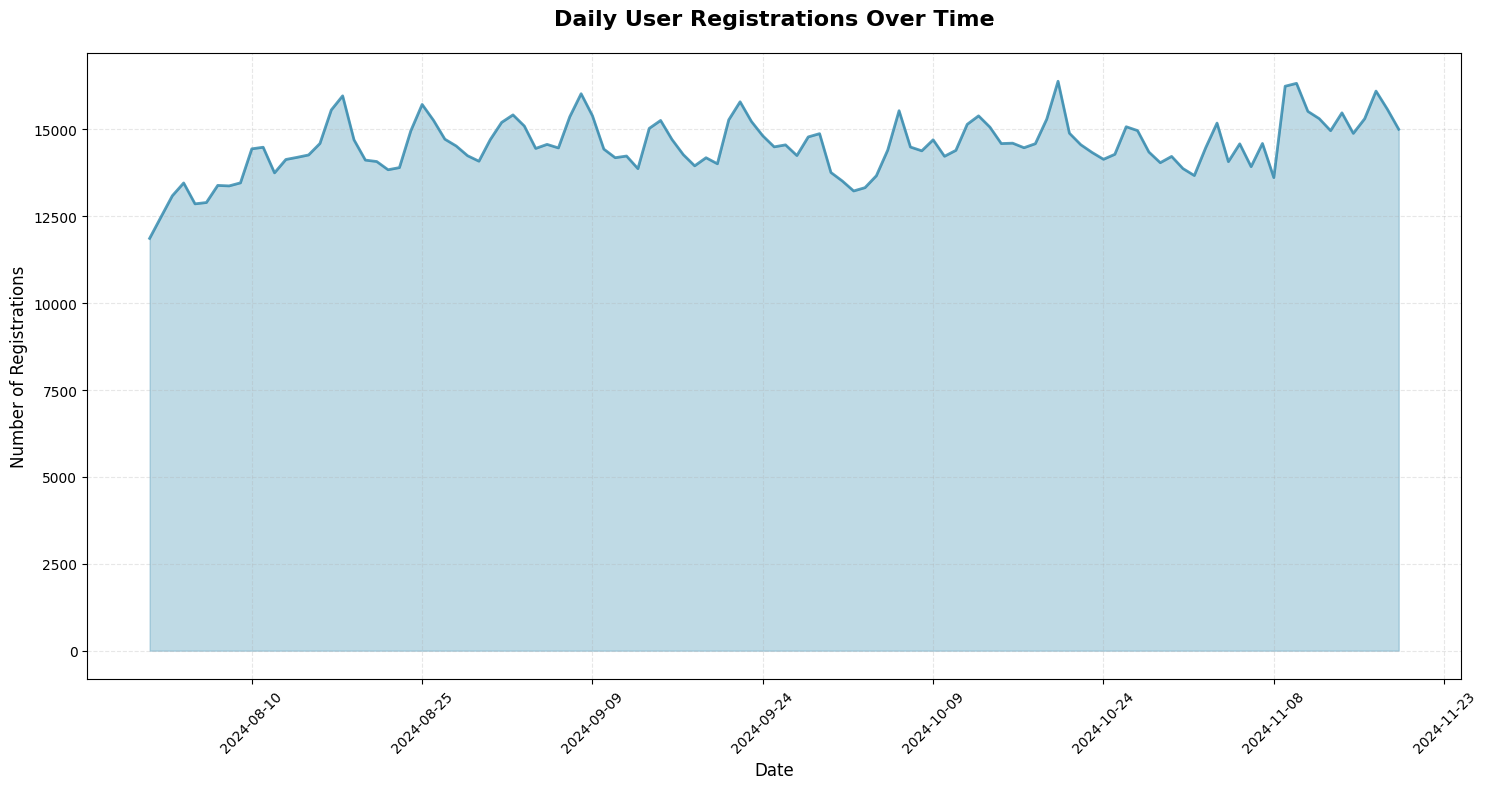

In [31]:
daily_counts = (
    df_user_params['timestamp_reg']
      .dt.date
      .value_counts()
      .sort_index()
)

plt.figure(figsize=(15, 8))
plt.plot(daily_counts.index, daily_counts.values, linewidth=2, color='#2E86AB', alpha=0.8)
plt.fill_between(daily_counts.index, daily_counts.values, alpha=0.3, color='#2E86AB')

plt.title('Daily User Registrations Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Registrations', fontsize=12)

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### Check for outliers

In [32]:
print("\nAGE (<13 or >100):", ((df_user_params['age'] < 13) | (df_user_params['age'] > 100)).sum())


AGE (<13 or >100): 22


In [33]:
for age in range(95, 101):
   count = (df_user_params['age'] == age).sum()
   print(f"Age {age}: {count} users")

Age 95: 682 users
Age 96: 564 users
Age 97: 549 users
Age 98: 2048 users
Age 99: 8 users
Age 100: 14 users


The thr is >98 to mark as invalid age.

In [34]:
df_user_params[df_user_params['age'] == 0]

,id_user,timestamp_reg,age,traffic_type_id,traffic_group_id,gender,country,device_browser,device_brand,device_model,device_platform,device_os,revenue_7d
18133,60905,2024-08-23 12:55:59.171020+00:00,0,3,4,male,US,NaN,NaN,NaN,NaN,NaN,0.0
63250,210602,2024-08-13 22:10:09.504020+00:00,0,2,9,male,US,Chrome,NaN,NaN,desktop,Windows,0.0
149641,499133,2024-08-24 12:40:32.100659+00:00,0,2,8,male,NaN,Safari,Apple,NaN,desktop,Mac,0.0
160760,536238,2024-11-04 12:07:35.105352+00:00,0,2,11,male,ZA,Firefox,NaN,NaN,desktop,Windows,0.0
481020,1606243,2024-11-19 01:46:29.926133+00:00,0,2,3,male,US,Facebook,Samsung,SM-S711U,mobile,Android,0.0
669544,2233605,2024-11-15 20:54:23.744659+00:00,0,2,6,male,CA,Chrome Mobile,Samsung,Galaxy S21 FE 5G,mobile,Android,0.0
935939,3122331,2024-08-14 03:00:27.367986+00:00,0,3,4,male,NaN,Chrome Mobile,Samsung,SM-S146VL,mobile,Android,0.0
953131,3179952,2024-10-24 06:00:39.143262+00:00,0,3,4,male,NaN,Chrome Mobile,Motorola,Moto G 5G,mobile,Android,0.0
1026094,3421905,2024-08-26 12:40:30.475240+00:00,0,1,7,male,NaN,Chrome Mobile,Samsung,Galaxy S23,mobile,Android,0.0
1060875,3538225,2024-11-14 05:43:02.225411+00:00,0,2,6,male,CA,Chrome Mobile,Samsung,Galaxy S21 FE 5G,mobile,Android,0.0


In [35]:
df_user_params['age'] = df_user_params['age'].mask(
    (df_user_params['age'] == 0) | (df_user_params['age'] > 98),
    other=pd.NA
)

Mark these ages as Nan. Also, these rows can be invalid in general.

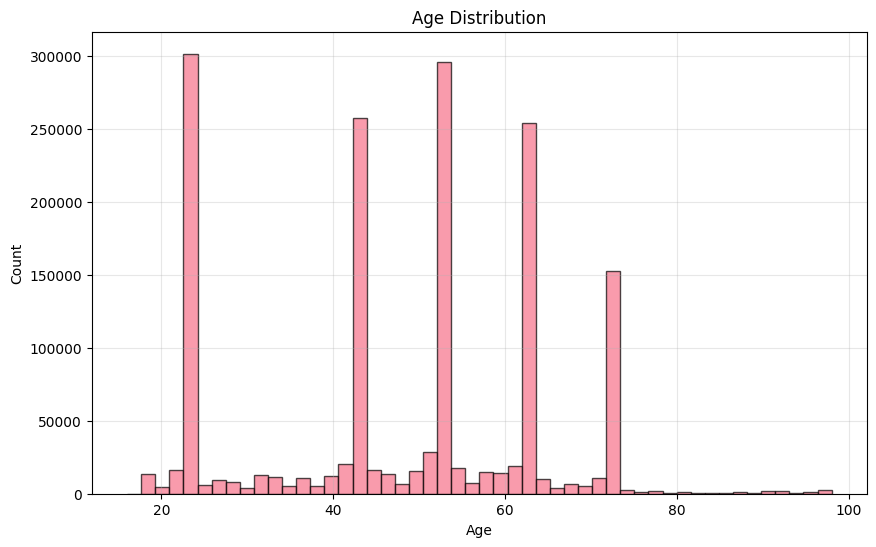

Age stats: Min=16.0, Max=98.0
Median age: 53.0


In [36]:
plt.figure(figsize=(10, 6))
plt.hist(df_user_params['age'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Age stats: Min={df_user_params['age'].min()}, Max={df_user_params['age'].max()}")
print(f"Median age: {df_user_params['age'].median()}")

In [37]:
df_user_params.traffic_type_id.value_counts()

traffic_type_id
1    811128
2    707505
3     95567
Name: count, dtype: int64

In [38]:
df_user_params.traffic_group_id.value_counts()

traffic_group_id
1     583569
3     255638
5     176531
6     149742
4      95567
8      89405
2      63788
11     54070
7      51028
9      47548
10     27348
12     19966
Name: count, dtype: int64

In [39]:
pd.crosstab(
    df_user_params['traffic_type_id'],
    df_user_params['traffic_group_id']
)

traffic_group_id,1,2,3,4,5,6,7,8,9,10,11,12
traffic_type_id,,,,,,,,,,,,
1,583569,0,0,0,176531,0,51028,0,0,0,0,0
2,0,63788,255638,0,0,149742,0,89405,47548,27348,54070,19966
3,0,0,0,95567,0,0,0,0,0,0,0,0


In [40]:
df_user_params.gender.value_counts()

gender
male      1418474
female     195726
Name: count, dtype: int64

In [41]:
import pycountry

codes = df_user_params.country.unique().tolist()

valid_codes = {c.alpha_2 for c in pycountry.countries}

invalid = [c for c in codes if c and c not in valid_codes]
print("Unrecognized codes:", invalid)

Unrecognized codes: [nan, 'XK']


XK is suppsoed to be Kosovo.

In [42]:
df_user_params.device_browser.value_counts()

device_browser
Chrome Mobile         642088
Facebook              346545
Mobile Safari         169492
Instagram App          96185
Chrome                 85981
                       ...  
Hawk Turbo Browser         1
QtWebEngine                1
SeaMonkey                  1
Baidu Browser              1
Internet Explorer          1
Name: count, Length: 127, dtype: int64

In [43]:
counts = df_user_params['device_browser'].value_counts()

print("Top 20 browsers:\n", counts.head(20))
print("\nNumber of unique browser strings:", len(counts))

rare = counts[counts < 1000].index.tolist()
print(f"\nBrowsers with <1000 users ({len(rare)}):")
print(rare)

Top 20 browsers:
 device_browser
Chrome Mobile            642088
Facebook                 346545
Mobile Safari            169492
Instagram App             96185
Chrome                    85981
Samsung Browser           56462
Chrome Webview            34071
Microsoft Edge            30930
Chrome Mobile iOS         30668
Google Search App         24565
Safari                    16167
Firefox                   14445
Facebook Lite             13285
TikTok                     6950
Opera Mobile               6568
Firefox Mobile             5656
Opera                      4265
Mobile Silk                3168
Snapchat                   3036
Huawei Browser Mobile      1705
Name: count, dtype: int64

Number of unique browser strings: 127

Browsers with <1000 users (102):
['Firefox Mobile iOS', 'Aloha Browser', 'HeyTapBrowser', 'Opera GX', 'vivo Browser', 'Avast Secure Browser', 'Yandex Browser', 'UNK', 'UC Browser', 'Kik', 'NetFront', 'AOL Desktop', 'AVG Secure Browser', 'Oculus Browser', 'DuckD

In [44]:
df_user_params.device_brand.value_counts()

device_brand
Samsung      523830
Apple        417688
Motorola     158157
Xiaomi        42947
Huawei        28928
              ...  
JAY-Tech          1
EXO               1
Prestigio         1
Cwowdefu          1
MicroMax          1
Name: count, Length: 356, dtype: int64

In [45]:
brand_counts = df_user_params['device_brand'].value_counts(dropna=False)

print("Top 20 device brands:\n", brand_counts.head(20))

threshold = 100

rare_brands = brand_counts[brand_counts < threshold].index.tolist()

print(f"\nBrands with fewer than {threshold} users ({len(rare_brands)}):")
print(rare_brands)

Top 20 device brands:
 device_brand
Samsung         523830
Apple           417688
NaN             248037
Motorola        158157
Xiaomi           42947
Huawei           28928
OPPO             27320
Tecno Mobile     16337
Google           14643
Nokia            13951
TCL              12746
Infinix          10734
LG                9523
Vivo              9367
OnePlus           7880
ZTE               6196
iTel              5531
Realme            5376
T-Mobile          5276
Blu               5069
Name: count, dtype: int64

Brands with fewer than 100 users (295):
['Vodacom', 'Acer', 'Fujitsu', 'Zuum', 'Unihertz', 'Sonim', 'Cellution', 'MobiWire', 'Symphony', 'NUU Mobile', 'Multilaser', 'Gplus', 'ComTrade Tesla', 'General Mobile', 'Anker', 'Kalley', 'Verizon', 'Moxee', 'Vsmart', 'RIM', 'Doro', 'Crosscall', 'Lava', 'IMO Mobile', 'Kodak', 'RCA Tablets', 'AGM', 'Kazuna', 'Condor', 'Nintendo', 'OpelMobile', 'Leagoo', 'Bmobile', 'Gionee', 'Philco', 'Logic', 'Teclast', 'Ravoz', 'Hammer', 'Noblex', '

In [46]:
df_user_params.device_model.value_counts()

device_model
iPhone           258495
Moto g play       33225
Galaxy A14 5G     30068
SM-A156U          27184
Moto G 5G         22776
                  ...  
AH9210                1
Clear M950            1
C12 Pro               1
Griffe T2             1
RKF54A                1
Name: count, Length: 7198, dtype: int64

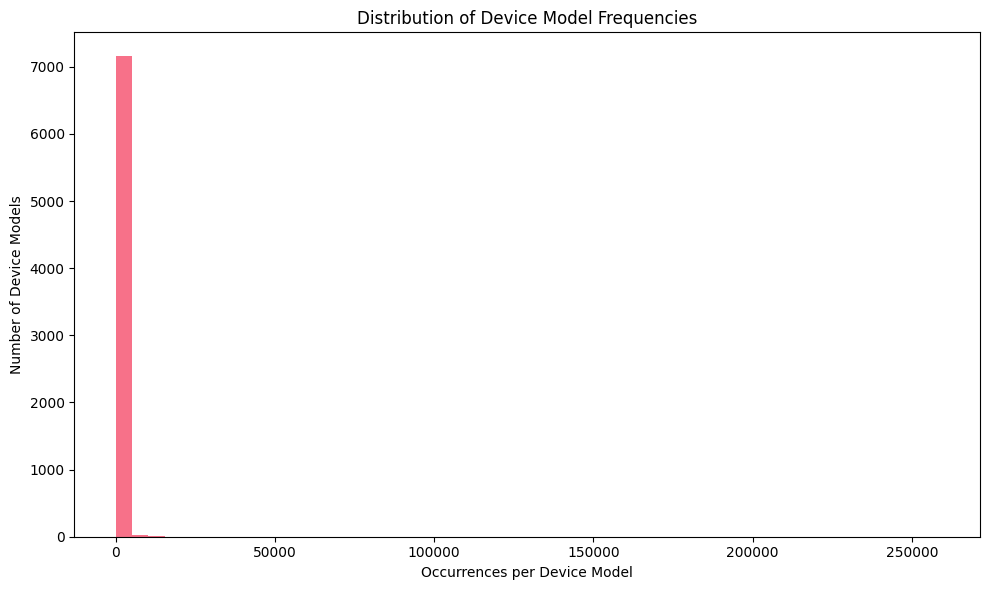

In [47]:
model_counts = df_user_params['device_model'].value_counts()

plt.figure(figsize=(10, 6))
plt.hist(model_counts, bins=50)
plt.title('Distribution of Device Model Frequencies')
plt.xlabel('Occurrences per Device Model')
plt.ylabel('Number of Device Models')
plt.tight_layout()
plt.show()

Need to be normalized

In [48]:
df_user_params.device_platform.value_counts()

device_platform
mobile     1435760
desktop     137111
tablet       33479
tv             636
console        326
car              1
Name: count, dtype: int64

In [49]:
df_user_params[df_user_params.device_platform == 'car']

,id_user,timestamp_reg,age,traffic_type_id,traffic_group_id,gender,country,device_browser,device_brand,device_model,device_platform,device_os,revenue_7d
103129,343447,2024-11-10 21:41:19.002740+00:00,50.0,1,1,male,CO,Chrome,Alps,8227L demo,car,Android,0.0


Filter car out.

In [50]:
df_user_params = df_user_params[df_user_params['device_platform'] != 'car']

In [51]:
df_user_params.device_os.value_counts()

device_os
Android           1073572
iOS                392420
Windows             99736
Mac                 23156
Chrome OS            8423
GNU/Linux            6698
iPadOS               2112
PlayStation           289
UNK                   265
Ubuntu                216
KaiOS                 202
Tizen                 114
HarmonyOS              86
Nintendo               37
Fedora                  4
Android TV              3
Windows Phone           2
Fire OS                 1
ClearOS Mobile          1
Wear OS                 1
Name: count, dtype: int64

In [52]:
print("NEGATIVE 7-DAY REVENUE:", (df_user_params['revenue_7d'] < 0).sum())

NEGATIVE 7-DAY REVENUE: 0


In [53]:
df_user_params.revenue_7d.value_counts()

revenue_7d
0.00      1579810
1.50         7026
9.99         5382
5.00         5097
11.49        1248
           ...   
57.28           1
32.35           1
171.41          1
579.91          1
61.70           1
Name: count, Length: 3056, dtype: int64

In [54]:
revenue = df_user_params['revenue_7d'].fillna(0)

bins = [0, 0.0001, 1, 2, 3, 4, 5, 10, 50, 100, 500, 1000, revenue.max()]

cats = pd.cut(revenue, bins=bins, right=False)

counts = cats.value_counts().sort_index()

print("Revenue bins and their counts:")
print(counts)

Revenue bins and their counts:
revenue_7d
[0.0, 0.0001)         1579810
[0.0001, 1.0)               0
[1.0, 2.0)               8721
[2.0, 3.0)                101
[3.0, 4.0)                  2
[4.0, 5.0)                  2
[5.0, 10.0)             11441
[10.0, 50.0)             8157
[50.0, 100.0)            2195
[100.0, 500.0)           3102
[500.0, 1000.0)           419
[1000.0, 20409.58)        248
Name: count, dtype: int64


In [55]:
df_user_actions.sum_payments.value_counts()

sum_payments
0.00      6427758
9.99         6306
1.50         5841
5.00         4420
11.49         894
           ...   
42.50           1
344.56          1
31.32           1
25.79           1
14.92           1
Name: count, Length: 1550, dtype: int64

In [56]:
payments = df_user_actions['sum_payments'].fillna(0)

bins = [0, 0.0001, 1, 2, 3, 4, 5, 10, 50, 100, 500, 1000, payments.max()]

cats = pd.cut(payments, bins=bins, right=False)

counts = cats.value_counts().sort_index()

print("payments bins and their counts:")
print(counts)

payments bins and their counts:
sum_payments
[0.0, 0.0001)       6427758
[0.0001, 1.0)             0
[1.0, 2.0)             6416
[2.0, 3.0)              948
[3.0, 4.0)                0
[4.0, 5.0)                1
[5.0, 10.0)           11540
[10.0, 50.0)           6766
[50.0, 100.0)          1688
[100.0, 500.0)         1652
[500.0, 1000.0)          30
[1000.0, 2446.8)          9
Name: count, dtype: int64


In [57]:
merged = df_user_actions.merge(df_user_params[['id_user', 'revenue_7d']], on='id_user', how='inner')
print("\nFIRST-DAY PAYMENTS > 7-DAY REVENUE:", (merged['sum_payments'] > merged['revenue_7d']).sum())
print("PAYMENTS BUT ZERO 7-DAY REVENUE:", ((merged['sum_payments'] > 0) & (merged['revenue_7d'] == 0)).sum())
print("7-DAY REVENUE BUT NO FIRST-DAY PAYMENTS:", ((merged['revenue_7d'] > 0) & (merged['sum_payments'] == 0)).sum())


FIRST-DAY PAYMENTS > 7-DAY REVENUE: 3456
PAYMENTS BUT ZERO 7-DAY REVENUE: 186
7-DAY REVENUE BUT NO FIRST-DAY PAYMENTS: 108692


In [58]:
bad1 = merged[merged['sum_payments'] > merged['revenue_7d']]
bad1.head()

,id_user,timestamp_interval_start,timestamp_interval_end,sum_payments,cnt_payments,sum_credits_spend,cnt_returns,cnt_visit_other_users,revenue_7d
3896,3442908,2024-08-20 08:01:47.089699+00:00,2024-08-20 14:01:47.089699+00:00,2.33,1,18,0,3,1.94
3980,434449,2024-08-20 08:04:23.087204+00:00,2024-08-20 14:04:23.087204+00:00,1.50,1,16,0,16,0.00
4028,4956128,2024-08-20 08:06:34.132686+00:00,2024-08-20 14:06:34.132686+00:00,13.30,1,70,0,5,11.08
7308,2707737,2024-08-01 00:57:21.175728+00:00,2024-08-01 06:57:21.175728+00:00,1.94,1,0,0,6,1.62
8316,1829918,2024-08-01 01:25:10.681627+00:00,2024-08-01 07:25:10.681627+00:00,1.94,1,20,0,13,1.62


Drop values.

In [59]:
bad_ids = bad1['id_user'].unique()

df_user_params = df_user_params[~df_user_params['id_user'].isin(bad_ids)].reset_index(drop=True)

df_user_actions = df_user_actions[~df_user_actions['id_user'].isin(bad_ids)].reset_index(drop=True)

In [60]:
df_user_actions.cnt_payments.value_counts()

cnt_payments
0     6417523
1       18340
2        4000
3        1538
4         711
5         347
6         194
7         106
8          86
9          57
10         40
11         25
12         21
13         17
14          8
18          7
16          7
15          6
20          4
23          4
17          4
27          2
19          2
28          1
26          1
22          1
55          1
Name: count, dtype: int64

In [61]:
credits = df_user_actions['sum_credits_spend'].fillna(0)

bins = [0, 0.0001, 1, 2, 3, 4, 5, 10, 50, 100, 500, 1000, credits.max()]

cats = pd.cut(credits, bins=bins, right=False)

counts = cats.value_counts().sort_index()

print("credits bins and their counts:")
print(counts)

credits bins and their counts:
sum_credits_spend
[0.0, 0.0001)        5612322
[0.0001, 1.0)              0
[1.0, 2.0)             16521
[2.0, 3.0)             17706
[3.0, 4.0)             16451
[4.0, 5.0)             17298
[5.0, 10.0)            82870
[10.0, 50.0)          663700
[50.0, 100.0)           6372
[100.0, 500.0)          8551
[500.0, 1000.0)          845
[1000.0, 15730.0)        416
Name: count, dtype: int64


In [62]:
df_user_actions.cnt_returns.value_counts()

cnt_returns
0    6443053
Name: count, dtype: int64

In [63]:
df_user_actions.drop(columns=['cnt_returns'], inplace=True)

Drop cnt_returns because of zero representative values

In [64]:
df_user_actions.cnt_visit_other_users.value_counts()

cnt_visit_other_users
0      5329873
1       347645
2       198476
3       132782
4        94502
        ...   
260          1
401          1
364          1
352          1
343          1
Name: count, Length: 345, dtype: int64

In [65]:
visits = df_user_actions['cnt_visit_other_users'].fillna(0)

bins = [0, 0.0001, 1, 2, 3, 4, 5, 10, 50, 100, 500, visits.max()]

cats = pd.cut(visits, bins=bins, right=False)

counts = cats.value_counts().sort_index()

print("visits bins and their counts:")
print(counts)

visits bins and their counts:
cnt_visit_other_users
[0.0, 0.0001)     5329873
[0.0001, 1.0)           0
[1.0, 2.0)         347645
[2.0, 3.0)         198476
[3.0, 4.0)         132782
[4.0, 5.0)          94502
[5.0, 10.0)        206039
[10.0, 50.0)       126639
[50.0, 100.0)        5688
[100.0, 500.0)       1397
[500.0, 851.0)         11
Name: count, dtype: int64


In [66]:
df_user_actions

,id_user,timestamp_interval_start,timestamp_interval_end,sum_payments,cnt_payments,sum_credits_spend,cnt_visit_other_users
0,2672114,2024-08-20 07:07:14.493905+00:00,2024-08-20 13:07:14.493905+00:00,0.0,0,0,2
1,2672114,2024-08-20 13:07:14.493905+00:00,2024-08-20 19:07:14.493905+00:00,0.0,0,0,0
2,2672114,2024-08-20 19:07:14.493905+00:00,2024-08-21 01:07:14.493905+00:00,0.0,0,0,0
3,2672114,2024-08-21 01:07:14.493905+00:00,2024-08-21 07:07:14.493905+00:00,0.0,0,0,0
4,4314012,2024-08-20 07:07:25.610218+00:00,2024-08-20 13:07:25.610218+00:00,0.0,0,0,4
...,...,...,...,...,...,...,...
6443048,2123445,2024-09-30 09:43:23.003217+00:00,2024-09-30 15:43:23.003217+00:00,0.0,0,0,0
6443049,2808871,2024-09-29 15:43:26.468557+00:00,2024-09-29 21:43:26.468557+00:00,0.0,0,0,1
6443050,2808871,2024-09-29 21:43:26.468557+00:00,2024-09-30 03:43:26.468557+00:00,0.0,0,0,0
6443051,2808871,2024-09-30 03:43:26.468557+00:00,2024-09-30 09:43:26.468557+00:00,0.0,0,0,0


## Column normalization

In [67]:
df_user_params = df_user_params.drop(columns=['traffic_type_id'])

Drop the traffic type because each group implies its type

In [68]:
df_user_params['device_brand'].value_counts()

device_brand
Samsung     522617
Apple       416603
Motorola    158068
Xiaomi       42770
Huawei       28830
             ...  
MOVISUN          1
SFR              1
Mione            1
Kanji            1
Contixo          1
Name: count, Length: 355, dtype: int64

In [69]:
df_user_params['device_brand'].str.strip().str.replace(r'\s+', ' ', regex=True).str.lower().value_counts()

device_brand
samsung     522617
apple       416603
motorola    158068
xiaomi       42770
huawei       28830
             ...  
movisun          1
sfr              1
mione            1
kanji            1
contixo          1
Name: count, Length: 355, dtype: int64

In [70]:
df_user_params[df_user_params['device_brand'].str.contains('oppo' ,case=False, na=False)].device_brand.value_counts()

device_brand
OPPO    27244
Name: count, dtype: int64

Are all brands valid?

In [71]:
df_user_params[
    df_user_params['device_model']
    .str.contains("Phone", case=False, na=False)
].device_model.unique()

array(['iPhone', 'iPhone 13', 'ROG Phone 2', 'smartphone', 'Smartphone',
       'iPhone XR', 'Pocophone F1', 'iPhone 8', 'T Phone Pro',
       'iPhone 11 Pro Max', 'iPhone SE (2020)', 'iPhone 12 Mini',
       'iPhone 12 Pro', 'ROG Phone 6D', 'iPhone 14 Pro Max', 'iPhone SE',
       'iPhone 12', 'Simple Smartphone 4', 'iPhone SE (2022)',
       'iPhone 11', 'iPhone X', 'iPhone 13 Pro', 'iPhone 13 Pro Max',
       'iPhone 8 Plus', 'iPhone 7', 'iPhone 12 Pro Max', 'iPhone XS Max',
       'iPhone 14 Plus', 'iPhone 14 Pro', 'iPhone 14', 'iPhone 6s',
       'Smartphone_X5', 'iPhone 13 Mini', 'iPhone 11 Pro',
       'iPhone 7 Plus', 'iPhone XS', 'iPhone 6', 'iPhone 6s Plus',
       'iPhone 6 Plus', 'ROG Phone 6', 'ROG Phone 5', '5G UG Phone U23',
       'iPhone 5S', 'ROG Phone 3', 'ThinkPhone by motorola', 'T Phone',
       'Qua Phone', 'Phone 2', 'afriphone S10', 'Leica Leitz Phone 2',
       'Easy Phone F-03K', 'Phone', 'PHONE', 'Qua Phone QX',
       'Smartphone 9.1', 'Easy Phone F-42A', '

In [72]:
df_user_params['device_model_clean'] = (
    df_user_params['device_model']
    .fillna('')
    .str.strip()
    .str.lower()
)

def find_similar_models(models, threshold=98):
    similar_groups = []
    processed = set()
    for i, m1 in enumerate(models):
        if not m1 or m1 in processed:
            continue
        group = [m1]
        processed.add(m1)
        for m2 in models[i+1:]:
            if m2 in processed:
                continue
            if fuzz.ratio(m1, m2) >= threshold:
                group.append(m2)
                processed.add(m2)
        if len(group) > 1:
            similar_groups.append(group)
    return similar_groups

unique_models = df_user_params['device_model_clean'].unique()
similar_groups = find_similar_models(unique_models, threshold=98)

mapping = {variant: group[0] for group in similar_groups for variant in group}

df_user_params['device_model_normalized'] = (
    df_user_params['device_model_clean']
    .map(lambda x: mapping.get(x, x))
)

df_user_params.drop(columns=['device_model_clean'], inplace=True)

In [73]:
df_user_params.drop(columns=['device_model'], inplace=True)

In [74]:
df_user_params.device_platform.value_counts()

device_platform
mobile     1432774
desktop     136754
tablet       33403
tv             634
console        326
Name: count, dtype: int64

In [75]:
df_user_params.device_os.value_counts()

device_os
Android           1071518
iOS                391425
Windows             99474
Mac                 23077
Chrome OS            8417
GNU/Linux            6684
iPadOS               2101
PlayStation           289
UNK                   265
Ubuntu                216
KaiOS                 202
Tizen                 114
HarmonyOS              86
Nintendo               37
Fedora                  4
Android TV              3
Windows Phone           2
Fire OS                 1
ClearOS Mobile          1
Wear OS                 1
Name: count, dtype: int64

In [76]:
frequency_counts = df_user_actions['id_user'].value_counts()

(frequency_counts == 5).sum()

9

In [77]:
ids_to_drop = frequency_counts[frequency_counts == 5].index

df_user_actions = df_user_actions[~df_user_actions['id_user'].isin(ids_to_drop)].reset_index(drop=True)
df_user_params  = df_user_params[~df_user_params['id_user'].isin(ids_to_drop)].reset_index(drop=True)

In [78]:
common_ids = set(df_user_actions['id_user']).intersection(df_user_params['id_user'])

df_user_actions = (
    df_user_actions
    [df_user_actions['id_user'].isin(common_ids)]
    .reset_index(drop=True)
)

df_user_params = (
    df_user_params
    [df_user_params['id_user'].isin(common_ids)]
    .reset_index(drop=True)
)

## Feature engineering

It's better to split data by id user and the date of registratiion, because the timesstamp is important here.

In [79]:
df_user_params['gender_bin'] = df_user_params['gender'].map({
    'male':   0,
    'female': 1
})

df_user_params.drop(columns=['gender'], inplace=True)

In [80]:
df_user_params['reg_month'] = df_user_params['timestamp_reg'].dt.to_period('M')

all_months = sorted(df_user_params['reg_month'].unique())

train_months = all_months[:-1]
test_months  = all_months[-1:]

/var/tmp/ipykernel_3476167/2030626514.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_user_params['reg_month'] = df_user_params['timestamp_reg'].dt.to_period('M')


In [81]:
all_months

[Period('2024-08', 'M'),
 Period('2024-09', 'M'),
 Period('2024-10', 'M'),
 Period('2024-11', 'M')]

In [82]:
df_user_params_train = df_user_params[df_user_params['reg_month'].isin(train_months)].copy()
df_user_params_test  = df_user_params[df_user_params['reg_month'].isin(test_months)].copy()

In [83]:
train_ids = set(df_user_params_train['id_user'])
test_ids  = set(df_user_params_test ['id_user'])

df_user_actions_train = (
    df_user_actions
    [df_user_actions['id_user'].isin(train_ids)]
    .reset_index(drop=True)
)

df_user_actions_test = (
    df_user_actions
    [df_user_actions['id_user'].isin(test_ids)]
    .reset_index(drop=True)
)

In [84]:
df_user_params_train['country'] = (
    df_user_params_train['country']
      .str.strip()                       
      .str.replace(r'\s+', ' ', regex=True)  
      .str.lower()                    
)

In [ ]:
df_user_params_train['country'].value_counts().to_dict()

In [85]:
train_counts = df_user_params_train['country'].value_counts()

min_users = 50
rare_countries = set(train_counts[train_counts < min_users].index)

df_user_params_train['country_normalized'] = df_user_params_train['country'].where(
    df_user_params_train['country'].isin(rare_countries) == False,
    other='Other'
)

In [86]:
df_user_params_train.drop(columns=['country'], inplace=True)

In [87]:
df_user_params_train['device_browser'] = (
    df_user_params_train['device_browser']
      .str.strip()                             
      .str.replace(r'\s+', ' ', regex=True)     
      .str.lower()
)

In [ ]:
df_user_params_train.device_browser.value_counts().to_dict()

In [89]:
browser_counts = df_user_params_train['device_browser'].value_counts()

min_users = 20
rare_browsers = set(browser_counts[browser_counts < min_users].index)

df_user_params_train['browser_normalized'] = df_user_params_train['device_browser'].where(
    ~df_user_params_train['device_browser'].isin(rare_browsers),
    other='Other'
)

In [90]:
df_user_params_train.drop(columns=['device_browser'], inplace=True)

In [91]:
df_user_params_train['device_brand'] = (
    df_user_params_train['device_brand']
      .str.strip()
      .str.replace(r'\s+', ' ', regex=True)
      .str.lower()
)

In [ ]:
df_user_params_train.device_brand.value_counts().to_dict()

In [93]:
brand_counts = df_user_params_train['device_brand'].value_counts()

min_users_brand = 25
rare_brands = set(brand_counts[brand_counts < min_users_brand].index)

df_user_params_train['brand_normalized'] = df_user_params_train['device_brand'].where(
    ~df_user_params_train['device_brand'].isin(rare_brands),
    other='Other'
)

In [94]:
df_user_params_train.drop(columns=['device_brand'], inplace=True)

In [95]:
df_user_params_train.device_platform.value_counts()

device_platform
mobile     1178343
desktop     113455
tablet       27821
tv             537
console        261
Name: count, dtype: int64

In [96]:
df_user_params_train['device_platform_normalized'] = (
    df_user_params_train['device_platform']
      .str.strip()
      .str.lower()
)

df_user_params_train['device_platform_normalized'] = (
    df_user_params_train['device_platform_normalized']
      .astype('category')
)

In [97]:
df_user_params_train.drop(columns=['device_platform'], inplace=True)

In [ ]:
df_user_params_train.device_os.value_counts()

In [98]:
brand_counts = df_user_params_train['device_os'].value_counts()

min_users_brand = 10
rare_brands = set(brand_counts[brand_counts < min_users_brand].index)

df_user_params_train['device_os_normalized'] = df_user_params_train['device_os'].where(
    ~df_user_params_train['device_os'].isin(rare_brands),
    other='Other'
)

In [99]:
df_user_params_train.drop(columns=['device_os'], inplace=True)

The possible features with timestamp_reg  are current - timestamp_reg; Time of day; is weekend

In [100]:
df_user_params_train['reg_weekday']= df_user_params_train['timestamp_reg'].dt.weekday
df_user_params_train['reg_hour']   = df_user_params_train['timestamp_reg'].dt.hour

In [101]:
df_user_params_train.browser_normalized.value_counts()

browser_normalized
chrome mobile                 516400
facebook                      291436
mobile safari                 141472
instagram app                  79990
chrome                         71279
samsung browser                46434
chrome webview                 28245
chrome mobile ios              25334
microsoft edge                 25165
google search app              19952
safari                         13292
firefox                        12262
facebook lite                  11392
tiktok                          6077
opera mobile                    4890
firefox mobile                  4634
opera                           3512
mobile silk                     2583
snapchat                        2565
huawei browser mobile           1379
instabridge                     1253
phoenix browser                 1066
miui browser                     990
opera touch                      940
twitter                          922
firefox mobile ios               839
aloha browser      

In [102]:
agg_specs = {
  'sum_payments':       ['sum','mean','max','std'],
  'cnt_payments':       ['sum'],
  'sum_credits_spend':  ['sum'],
  'cnt_visit_other_users': ['sum'],
}

user_agg = df_user_actions_train.groupby('id_user').agg(agg_specs)

In [103]:
user_agg.columns = [
    f"{col}_{stat}" 
    for col, stat in user_agg.columns
]

In [104]:
df_user_params_train = df_user_params_train.merge(
    user_agg,
    left_on='id_user',
    right_index=True,
    how='left'          
)

In [106]:
country_counts = df_user_params_train['country_normalized'].value_counts()
allowed_countries = set(country_counts.index)

browser_counts = df_user_params_train['browser_normalized'].value_counts()
allowed_browsers = set(browser_counts.index)

brand_counts = df_user_params_train['brand_normalized'].value_counts()
allowed_brands = set(brand_counts.index)

os_counts = df_user_params_train['device_os_normalized'].value_counts()
allowed_oses = set(os_counts.index)

In [107]:
# -- country
x = (df_user_params_test['country']
      .str.strip()
      .str.replace(r'\s+', ' ', regex=True)
      .str.lower()
)
df_user_params_test['country_normalized'] = (
    x.where(x.isin(allowed_countries), other='Other')
      .where(df_user_params_test['country'].notna(), other=pd.NA)
      .astype('category')
)
df_user_params_test.drop(columns=['country'], inplace=True)

# -- browser
x = (df_user_params_test['device_browser']
      .str.strip()
      .str.replace(r'\s+', ' ', regex=True)
      .str.lower()
)
df_user_params_test['browser_normalized'] = (
    x.where(x.isin(allowed_browsers), other='Other')
      .where(df_user_params_test['device_browser'].notna(), other=pd.NA)
      .astype('category')
)
df_user_params_test.drop(columns=['device_browser'], inplace=True)

# -- brand
x = (df_user_params_test['device_brand']
      .str.strip()
      .str.replace(r'\s+', ' ', regex=True)
      .str.lower()
)
df_user_params_test['brand_normalized'] = (
    x.where(x.isin(allowed_brands), other='Other')
      .where(df_user_params_test['device_brand'].notna(), other=pd.NA)
      .astype('category')
)
df_user_params_test.drop(columns=['device_brand'], inplace=True)

# -- platform (just normalize casing/spaces; no rare‐bucketing)
df_user_params_test['device_platform_normalized'] = (
    df_user_params_test['device_platform']
      .str.strip()
      .str.lower()
      .where(df_user_params_test['device_platform'].notna(), other=pd.NA)
      .astype('category')
)
df_user_params_test.drop(columns=['device_platform'], inplace=True)

# -- os
x = df_user_params_test['device_os'].str.strip().str.lower()
df_user_params_test['device_os_normalized'] = (
    x.where(x.isin(allowed_oses), other='Other')
      .where(df_user_params_test['device_os'].notna(), other=pd.NA)
      .astype('category')
)
df_user_params_test.drop(columns=['device_os'], inplace=True)

In [108]:
df_user_params_test['reg_weekday'] = df_user_params_test['timestamp_reg'].dt.weekday
df_user_params_test['reg_hour']    = df_user_params_test['timestamp_reg'].dt.hour

agg_specs = {
    'sum_payments':         ['sum','mean','max','std'],
    'cnt_payments':         ['sum'],
    'sum_credits_spend':    ['sum'],
    'cnt_visit_other_users':['sum'],
}

user_agg_test = (
    df_user_actions_test
    .groupby('id_user')
    .agg(agg_specs)
)
user_agg_test.columns = [f"{col}_{stat}" for col, stat in user_agg_test.columns]

df_user_params_test = (
    df_user_params_test
    .merge(user_agg_test, left_on='id_user', right_index=True, how='left')
)

In [113]:
df_user_params_train['device_model_normalized'] = (
    df_user_params_train['device_model_normalized']
      .replace('', pd.NA)
)

df_user_params_test['device_model_normalized'] = (
    df_user_params_test['device_model_normalized']
      .replace('', pd.NA)
)

## modelling

In [115]:
FEATURES = [
  'age', 'traffic_group_id',
  'device_model_normalized', 'gender_bin',
  'country_normalized', 'browser_normalized',
  'brand_normalized', 'device_platform_normalized',
  'device_os_normalized', 'reg_weekday',
  'reg_hour', 'sum_payments_sum', 'sum_payments_mean',
  'sum_payments_max', 'sum_payments_std', 'cnt_payments_sum',
  'sum_credits_spend_sum', 'cnt_visit_other_users_sum'
]

In [116]:
TARGET = 'revenue_7d'

In [117]:
X_train = df_user_params_train[FEATURES].copy()
y_train = df_user_params_train[TARGET].copy()

X_test  = df_user_params_test[FEATURES].copy()
y_test  = df_user_params_test[TARGET].copy()


categorical_feats = [
    'device_model_normalized',
    'country_normalized',
    'browser_normalized',
    'brand_normalized',
    'device_platform_normalized',
    'device_os_normalized',
    'traffic_group_id'
]
for col in categorical_feats:
    X_train[col] = X_train[col].astype('category')
    X_test[col]  = X_test[col].astype('category')

In [118]:
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

In [119]:
lgb_train = lgb.Dataset(
    X_train, label=y_train_log,
    categorical_feature=categorical_feats,
    free_raw_data=False
)

lgb_valid = lgb.Dataset(
    X_test, label=y_test_log,
    categorical_feature=categorical_feats,
    reference=lgb_train,
    free_raw_data=False
)

In [120]:
%%time

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'feature_pre_filter': False,
    'verbose': -1
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=300,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['train','valid'],
    callbacks=[
        lgb.early_stopping(30),      
        lgb.log_evaluation(10)
    ]
)

Training until validation scores don't improve for 30 rounds
[10]	train's rmse: 0.306016	valid's rmse: 0.301263
[20]	train's rmse: 0.256776	valid's rmse: 0.254398
[30]	train's rmse: 0.236266	valid's rmse: 0.235416
[40]	train's rmse: 0.228108	valid's rmse: 0.228206
[50]	train's rmse: 0.224746	valid's rmse: 0.225562
[60]	train's rmse: 0.223247	valid's rmse: 0.224624
[70]	train's rmse: 0.222509	valid's rmse: 0.224288
[80]	train's rmse: 0.222029	valid's rmse: 0.22418
[90]	train's rmse: 0.22162	valid's rmse: 0.224144
[100]	train's rmse: 0.221244	valid's rmse: 0.224161
[110]	train's rmse: 0.220892	valid's rmse: 0.224188
Early stopping, best iteration is:
[88]	train's rmse: 0.221702	valid's rmse: 0.224144
CPU times: user 37.7 s, sys: 219 ms, total: 37.9 s
Wall time: 3.77 s


In [121]:
y_pred_log = gbm.predict(X_test, num_iteration=gbm.best_iteration)

y_pred = np.expm1(y_pred_log)

rmsle = np.sqrt(mean_squared_error(y_test_log, y_pred_log))

rmse  = np.sqrt(mean_squared_error(y_test, y_pred))

mae   = mean_absolute_error(y_test, y_pred)

print(f"RMSLE (log‐space RMSE): {rmsle:.4f}")
print(f"Original‐scale RMSE:   {rmse:.4f}")
print(f"Original‐scale MAE:    {mae:.4f}")

RMSLE (log‐space RMSE): 0.2241
Original‐scale RMSE:   20.2168
Original‐scale MAE:    0.6895


In [122]:
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

R²: 0.4753


In [123]:
ql_median = mean_pinball_loss(y_test, y_pred, alpha=0.5)
ql_90pct   = mean_pinball_loss(y_test, y_pred, alpha=0.9)
print(f"Pinball loss @ median (α=0.5): {ql_median:.4f}")
print(f"Pinball loss @ 90th pct (α=0.9): {ql_90pct:.4f}")

Pinball loss @ median (α=0.5): 0.3448
Pinball loss @ 90th pct (α=0.9): 0.5353


In [124]:
K = 0.01
n_top = int(len(y_test) * K)

top_actual_idx = np.argsort(y_test.values)[-n_top:]

top_pred_idx   = np.argsort(y_pred)[-n_top:]

coverage = len(set(top_actual_idx).intersection(top_pred_idx)) / n_top
print(f"Coverage of top {int(K*100)}% spenders: {coverage:.3%}")

Coverage of top 1% spenders: 68.097%


In [125]:
importance = gbm.feature_importance(importance_type='gain')
feature_names = gbm.feature_name()

fi_df = pd.DataFrame({
    'feature': feature_names,
    'gain': importance
}).sort_values('gain', ascending=False).reset_index(drop=True)

print(fi_df)

                       feature          gain
0             sum_payments_max  1.168734e+06
1             sum_payments_sum  4.285147e+05
2             sum_payments_std  1.638854e+04
3    cnt_visit_other_users_sum  1.594534e+04
4      device_model_normalized  7.281534e+03
5                          age  6.146040e+03
6             traffic_group_id  1.789179e+03
7           country_normalized  1.217923e+03
8        sum_credits_spend_sum  1.176851e+03
9             cnt_payments_sum  1.164205e+03
10                    reg_hour  9.527105e+02
11                 reg_weekday  3.982442e+02
12          browser_normalized  2.535610e+02
13                  gender_bin  9.438609e+01
14        device_os_normalized  8.024020e+01
15            brand_normalized  4.064743e+01
16  device_platform_normalized  0.000000e+00
17           sum_payments_mean  0.000000e+00


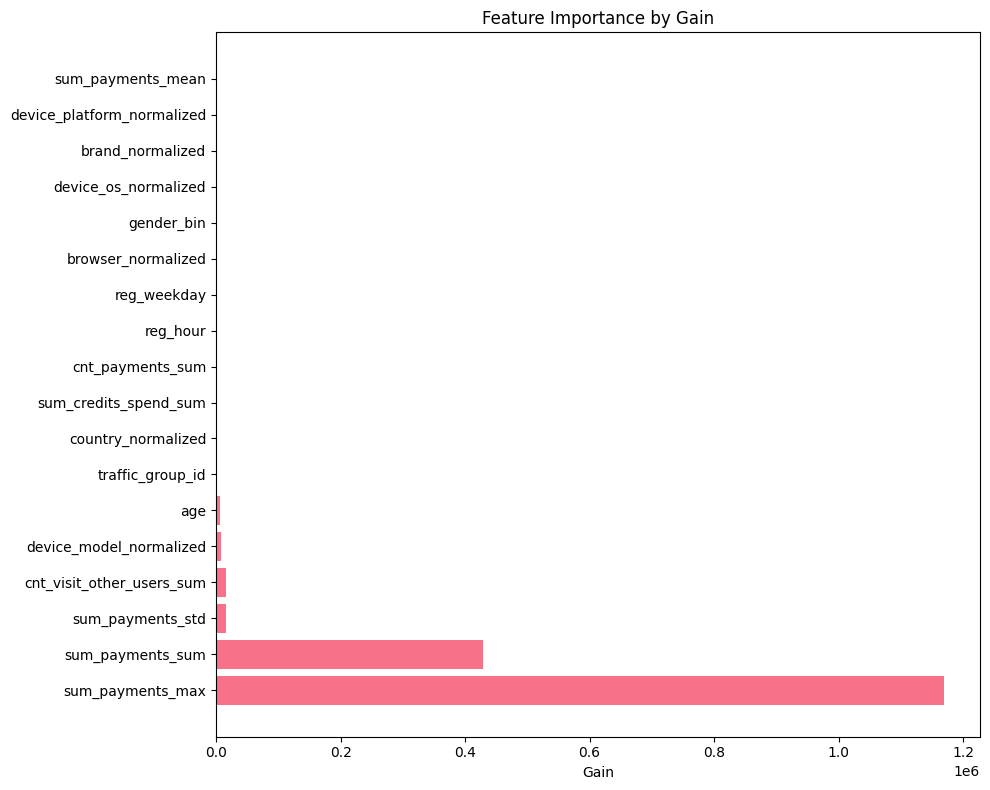

In [126]:
plt.figure(figsize=(10, 8))
plt.barh(fi_df['feature'], fi_df['gain'])
plt.xlabel('Gain')
plt.title('Feature Importance by Gain')
plt.tight_layout()
plt.show()

We can say that:
Payment behavior on day 1 is the strongest feature. Users who pay more immediately are highly likely to spend more over the subsequent week.
Demographics and "device" features add only marginal incremental lift beyond that. 

Weak features can be dropped.